## OVERVIEW

The objective here is to test the performance of different electricity provisioning algorithms based on the demand predictions that we already have. We will be using the below objective function for performance measurement.

$\sum \limits _{t=1} ^ {T} $p(t)$*$x(t) + a$*max{(0,y[t]-x[t])} + b $* | (x[t]-x[t-1]) | 

### Getting Started

Lets first import libraries and the energy usage dataset for three houses (B, C, F). We need to preprocess the data to make it usable.

In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore")

# Loading the data from csv files

energyB = pd.read_csv('../Assignment 1 /data/HomeB-meter1_2014.csv')
energyC = pd.read_csv('../Assignment 1 /data/HomeC-meter1_2016.csv')
energyF = pd.read_csv('../Assignment 1 /data/HomeF-meter3_2016.csv')

### Preprocessing Data
1. We need to convert timestamp to date time data structure
2. We need to convert the 3 datasets into bi-hourly buckets. Hence we group it into half hourly aggregates. House C & F were having minute level data.
3. As per the question we need to consider the timeline from 1st Nov to 14th Nov, hence we extract the data points for that duration.

In [2]:
# Date column -> datetime object
energyB['Date & Time']= pd.to_datetime(energyB['Date & Time']) 
energyC['Date & Time']= pd.to_datetime(energyC['Date & Time']) 
energyF['Date & Time']= pd.to_datetime(energyF['Date & Time']) 

In [3]:
start = "11-01-2014"
end = "11-15-2014"

energyB["Date & Time"] = energyB["Date & Time"].dt.floor(freq="30T")
energyB = energyB.groupby("Date & Time").sum().reset_index()

energyB = energyB.loc[energyB["Date & Time"] >= start]
energyB = energyB.loc[energyB["Date & Time"] < end]
energyB.reset_index(drop=True, inplace=True)
energyBdata = energyB['use [kW]']
energyBdata.index = np.arange(1, len(energyBdata) + 1)

In [4]:
start = "11-01-2016"
end = "11-15-2016"

energyC["Date & Time"] = energyC["Date & Time"].dt.floor(freq="30T")
energyC = energyC.groupby("Date & Time").sum().reset_index()

energyC = energyC.loc[energyC["Date & Time"] >= start]
energyC = energyC.loc[energyC["Date & Time"] < end]
energyC.reset_index(drop=True, inplace=True)
energyCdata = energyC['use [kW]']
energyCdata.index = np.arange(1, len(energyCdata) + 1)

In [5]:
start = "11-01-2016"
end = "11-15-2016"

energyF["Date & Time"] = energyF["Date & Time"].dt.floor(freq="30T")
energyF = energyF.groupby("Date & Time").sum().reset_index()

energyF = energyF.loc[energyF["Date & Time"] >= start]
energyF = energyF.loc[energyF["Date & Time"] < end]
energyF.reset_index(drop=True, inplace=True)
energyFdata = energyF['Usage [kW]']
energyFdata.index = np.arange(1, len(energyFdata) + 1)

In [6]:
plt.rcParams["figure.figsize"] = [21, 10] 
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['text.color'] = 'black'

def plot_graph_offline(prov_type, x, trueValues, house):
  plt.figure(figsize=(20, 5))
  plt.title("Actual vs Optimal values for Offline " + prov_type + " provisioning" + " House " + house)
  plt.plot(x, 'b', label="Optimal Values")
  plt.plot(trueValues, 'r', label="True Values")
  plt.legend()
  plt.ylabel("Electricity Units in kW")
  plt.xlabel("Time step t(1 unit = 15 minutes)")

In [7]:
#Store algorithms, optimal values and decision values for objective function
opt_dict_B = {}
opt_dict_C = {}
opt_dict_F = {}
decision_dict_B = {}
decision_dict_C = {}
decision_dict_F = {}
opt_dict = [opt_dict_B, opt_dict_C, opt_dict_F]
decision_dict = [decision_dict_B, decision_dict_C, decision_dict_F]
offline_static = []
houses = ['B', 'C', 'F']
energyData = [energyBdata, energyCdata, energyFdata]

## Offline Optimization Problem

### Offline Static Optimization

In case of Static Offline optimization, we do not consider the switching cost, so our objective function reduces to below:


$\sum \limits _{t=1} ^ {T} $p(t)$*$x(t) + a$*max{(0,y[t]-x[t])} 

To minimize this objective function for a given x, we use the library CVXPY. For this value of x, we then find the optimal value of cost.

The const. parameters we have here are :  
Price (p) = 0.4$/kwH = ( 0.4/2 ) $ / kW 30 min = 0.2$ / KW 30 min = 0.2  

a = b= 4$/kwH=2$/kw30min=2


In [8]:
def calc_static_provision_offline(house, data):
  price = 0.4/2 #Half hourly rate
  a = 4/2
  b = 4/2
  y = data.to_list()
  x = cp.Variable(1)

  cost = price*x + a*cp.maximum(0, y - x)
  objective = cp.Minimize(cp.sum(cost) + b*x)
  constraints = [0 <= x]
  problem = cp.Problem(objective, constraints)
  result = problem.solve()
  opt = pd.Series(np.full((672), x.value), index=data.index)

  print("The optimal value for static provisioning for house ", house ," is ", result)
  print("The optimal value of x for the same is: ", x.value)
  plot_graph_offline('static', opt, data, house)
  return result, opt

The optimal value for static provisioning for house  B  is  194.84252933729957
The optimal value of x for the same is:  [0.907565]
The optimal value for static provisioning for house  C  is  7989.918093270889
The optimal value of x for the same is:  [41.14206667]
The optimal value for static provisioning for house  F  is  19396.101745950808
The optimal value of x for the same is:  [119.74353333]


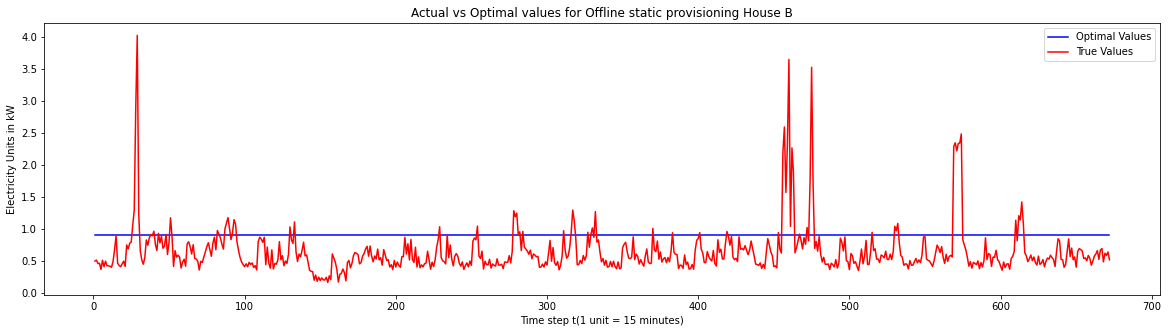

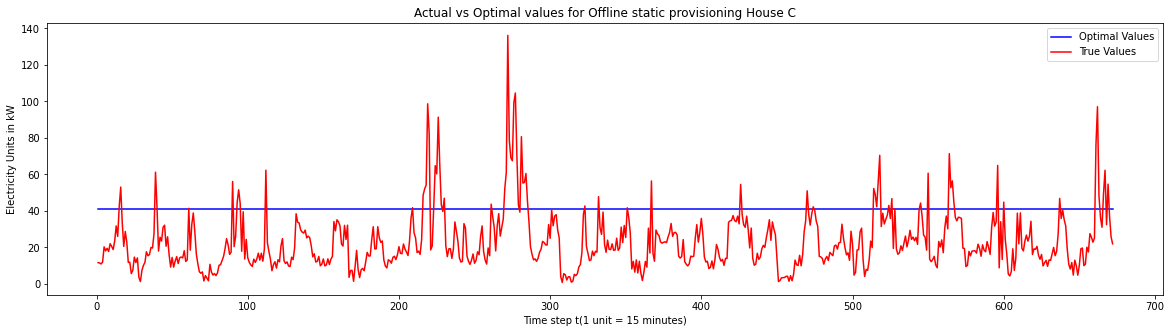

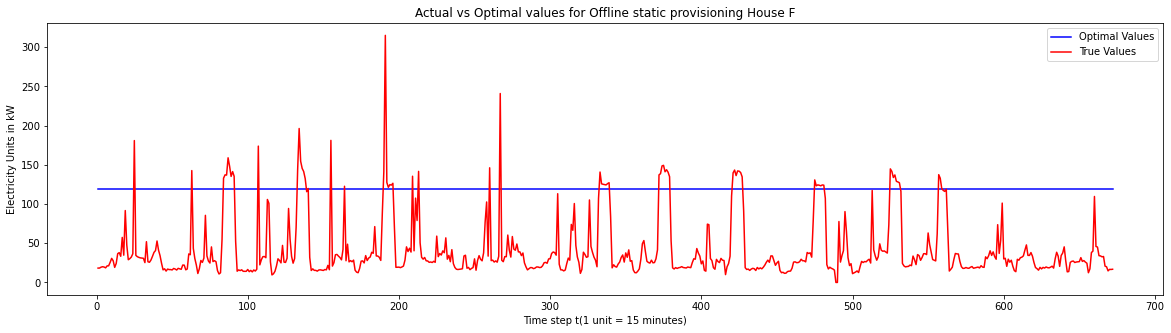

In [9]:
for i in range(3):
    result, opt = calc_static_provision_offline(houses[i] ,energyData[i])
    opt_dict[i]['Offline Static'] = result
    decision_dict[i]['Offline Static'] = opt
    offline_static.append(result)

As seen for the above graphs, for example: for house B, the static offline optimization gives the value of 0.907 kW and the objective function cost as 194.84. We get a straight line as optimal plot on graph as above, since this is a static optimisation.  

We get the below values as optimal cost using static offline optimization approach above.

In [10]:
comparison = pd.DataFrame({
    'House': houses,
    'Cost': offline_static,
})
comparison

,House,Cost
0,B,194.842529
1,C,7989.918093
2,F,19396.101746


### Offline Dynamic Optimization

In case of Dynamic Offline optimization, we do consider the previous values also, hence, so our objective function reduces to below:


$\sum \limits _{t=1} ^ {T} $p(t)$*$x(t) + a$*max{(0,y[t]-x[t])} + b $* | (x[t]-x[t-1]) | 

Similar to static offline optimizations, I am calculating the optimal cost and plotting the graph for each house.

In [11]:
def calc_dynamic_offline_provision(house, df):
  p = 0.4/2
  a = 4/2
  b = 4/2
  y = df.to_list()
  x = cp.Variable(672)
  cost = 0

  for i in range(1,672):
      cost += p*x[i] + a*cp.maximum(0, y[i-1] - x[i]) + b*cp.abs(x[i]-x[i-1])
  
  objective = cp.Minimize(cost)
  constraints = [x[0] == 0, x[1:] >= 0]
  problem = cp.Problem(objective, constraints)
  result = problem.solve()
  opt = pd.Series(np.array(x.value), index=df.index)


  print("\nThe optimal value of dynamic optimisation for House ", house, " is", result)
  plot_graph_offline('dynamic', opt, df, house)
  return result, opt



The optimal value of dynamic optimisation for House  B  is 161.34680706547033

The optimal value of dynamic optimisation for House  C  is 6696.918532777977

The optimal value of dynamic optimisation for House  F  is 14778.496106597464


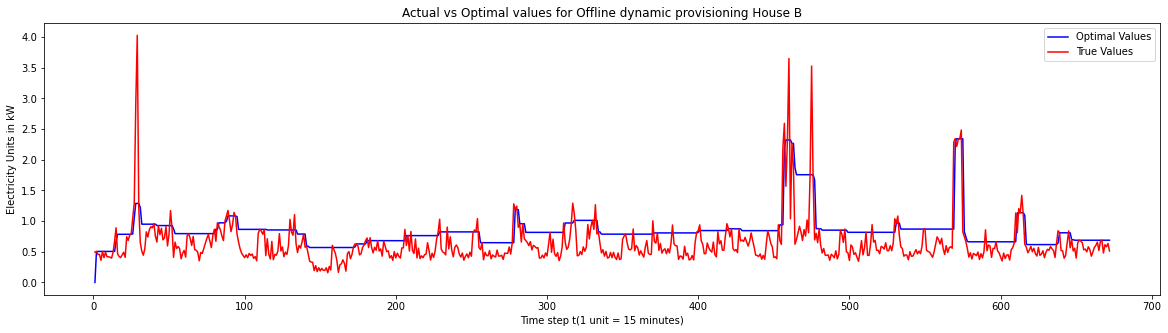

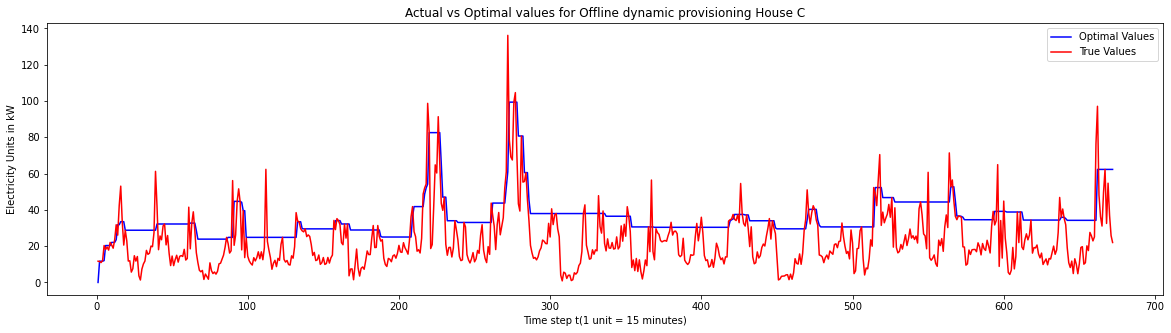

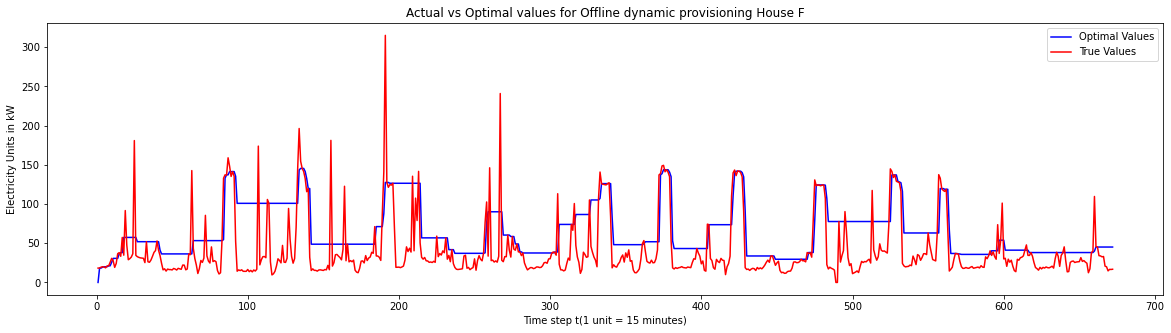

In [12]:
offline_dynamic = []
for i in range(3):
    result, opt = calc_dynamic_offline_provision(houses[i], energyData[i])
    opt_dict[i]['Offline Dynamic'] = result
    decision_dict[i]['Offline Dynamic'] = opt
    offline_dynamic.append(result)


In [13]:
comparison = pd.DataFrame({
    'House': houses,
    'Offline Static Cost': offline_static,
    'Offline Dynamic Cost': offline_dynamic,
})
comparison

,House,Offline Static Cost,Offline Dynamic Cost
0,B,194.842529,161.346807
1,C,7989.918093,6696.918533
2,F,19396.101746,14778.496107


# Online Algorithms

As part of online algorithms, I am exploring Online Gradient Descent (OGD), Receding Horizon Control (RHC) and Commitment Horizon Control (CHC) to find the optimal provision.

### ONLINE GRADIENT DESCENT

In case of online gradient descent, we find the value of x(t) iteratively using the previous values(x(t-1). The equation is as below:

x[t+1] = x[t] - learning_rate * (gradient)   


Here learning rate is the different step sizes we provide and observe how objective function value is changing for a range of learning rate.

In [14]:
def calc_cost(method, x, y, verbose):
    cost = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for i in range(1, len(y) + 1):
        cost += p * x[i] + a * max(0, y[i] - x[i] + b * abs(x[i] - x[i - 1]))
    if (verbose == True):                         
      print("\nThe objective value for " + method + " is", cost)
    return cost

In [15]:
def gradient(x, y, t, p, a, b):
    slope = 0

    if (y[t] > x[t]):
        if (x[t] > x[t - 1]):
            slope = p - a + b;
        else:
            slope = p - a - b;
    else:
        if (x[t] > x[t - 1]):
            slope = p + b;
        else:
            slope = p - b;
    return slope;

In [16]:
def online_gradient_descent(y, steps):
    n = len(y)
    x = [0.0] * (n + 1)
    x[1] = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for t in range(1, n):
        x[t + 1] = x[t] - steps * gradient(x, y, t, p, a, b)
    return x

In [17]:
x = online_gradient_descent(energyBdata, steps = 0.1)
calc_cost('Online Gradient Descent', x, energyBdata, True)


The objective value for Online Gradient Descent is 371.0574300160019


371.0574300160019

In [18]:
def plot_ogd(house, steps, costs):
    plt.figure(figsize=(20, 5))
    plt.title("Online Gradient Descent Optimal Cost for House " + house)
    plt.plot(steps, costs, label = "Cost")
    plt.legend()
    plt.ylabel("Cost Value")
    plt.xlabel("Step Size")
    plt.show()

In [19]:
def plot_comparison(house, optimalValues, trueValues):   
    plt.figure(figsize=(20, 5))
    plt.title("Actual vs Optimal | Online Gradient Descent | House " + house)
    plt.plot(optimalValues, 'b', label="Usage Values")
    plt.plot(trueValues, 'r', label="Provision Values")
    plt.legend()
    plt.ylabel("Electricity Units in kWH")
    plt.xlabel("Time step t(1 unit = 15 minutes)")

In [20]:
ogd= []

Results on Online Gradient Descent for House  B
Optimal cost found For House B at step:  0.022599999999999974

The objective value for Online Gradient Descent at Optimal cost for House B :  is 215.83683934600026


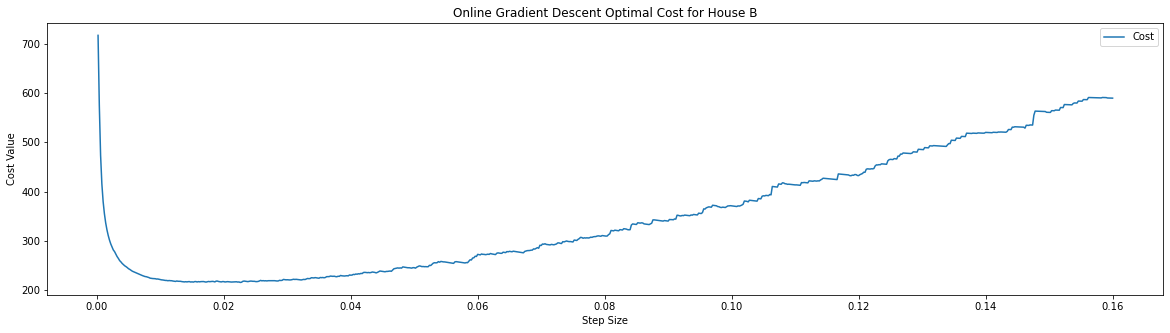

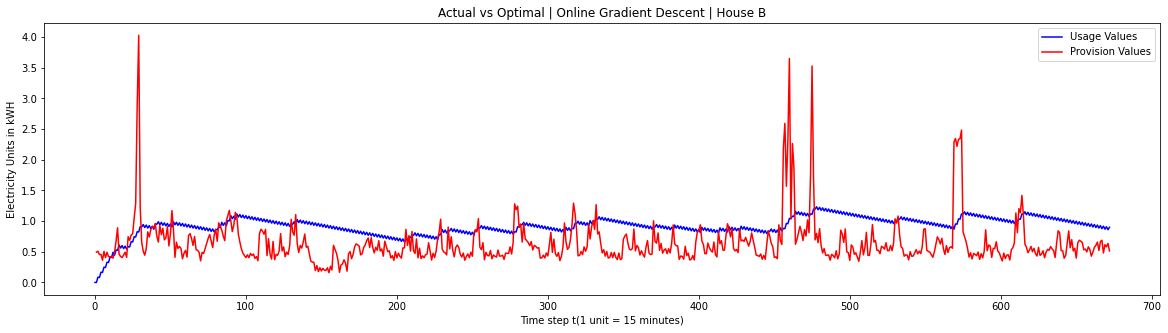

In [21]:
costs = []
steps = []
step = 0
i = 0
for k in range(800):
    step += 0.0002
    x = online_gradient_descent(energyData[i], steps = step)
    steps.append(step)
    costs.append(calc_cost("Cost", x ,energyData[i], False))

x = online_gradient_descent(energyBdata, steps = steps[costs.index(min(costs))])
print ("Results on Online Gradient Descent for House ", houses[i])
print("Optimal cost found For House B at step: ", steps[costs.index(min(costs))])
opt = calc_cost("Online Gradient Descent at Optimal cost for House B : ", x, energyBdata, True)
opt_dict[0]['OGD'] = opt
decision_dict[0]['OGD'] = x
ogd.append(opt)
plot_ogd("B", steps, costs)
plot_comparison("B", x, energyBdata)


Results on Online Gradient Descent for House  C
Optimal cost found at step:  0.8520000000000006

The objective value for Online Gradient Descent at Optimal cost is 8717.683653388014


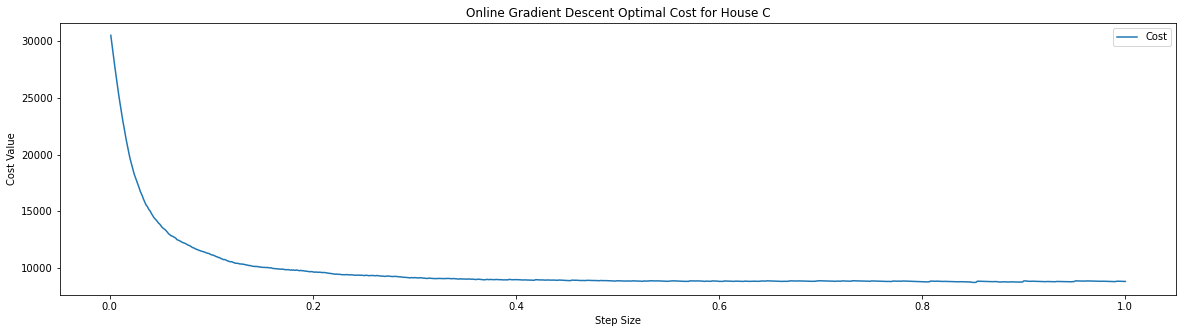

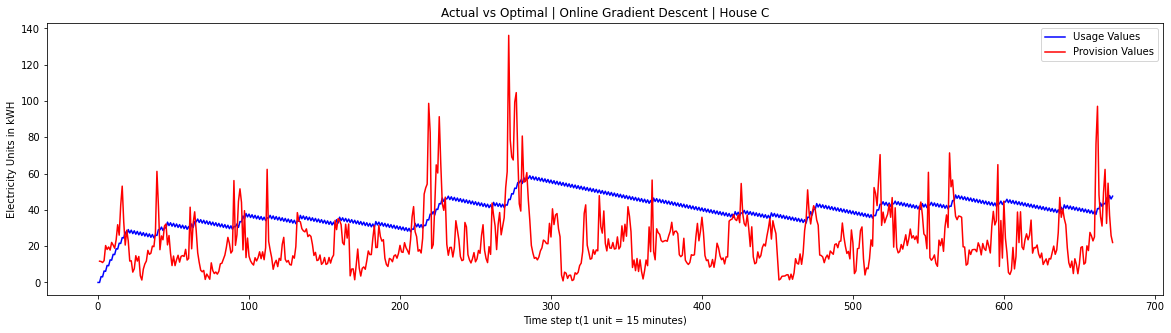

In [22]:
i = 1
costs = []
steps = []
step = 0
for k in range(1000):
    step += 0.001
    x = online_gradient_descent(energyData[i], steps = step)
    steps.append(step)
    costs.append(calc_cost("Cost", x ,energyData[i], False))

x = online_gradient_descent(energyData[i], steps = steps[costs.index(min(costs))])
print ("Results on Online Gradient Descent for House ", houses[i])
print("Optimal cost found at step: ", steps[costs.index(min(costs))])
opt = calc_cost("Online Gradient Descent at Optimal cost", x, energyData[i], True)
opt_dict[i]['OGD'] = opt
decision_dict[i]['OGD'] = x
ogd.append(opt)
plot_ogd(houses[i], steps, costs)
plot_comparison(houses[i], x, energyData[i])


Results on Online Gradient Descent for House  F
Optimal cost found at step:  0.9920000000000008

The objective value for Online Gradient Descent at Optimal cost is 22013.624520051995


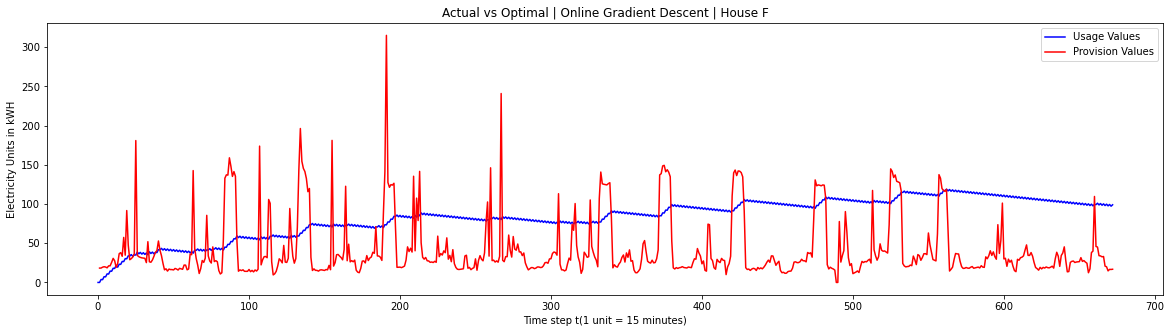

In [23]:
i = 2
costs = []
steps = []
step = 0
for k in range(1000):
    step += 0.001
    x = online_gradient_descent(energyData[i], steps = step)
    steps.append(step)
    costs.append(calc_cost("Cost", x ,energyData[i], False))

x = online_gradient_descent(energyData[i], steps = steps[costs.index(min(costs))])
print ("Results on Online Gradient Descent for House ", houses[i])
print("Optimal cost found at step: ", steps[costs.index(min(costs))])
opt = calc_cost("Online Gradient Descent at Optimal cost", x, energyData[i], True)
opt_dict[i]['OGD'] = opt
decision_dict[i]['OGD'] = x
ogd.append(opt)
plot_comparison(houses[i], x, energyData[i])

In [24]:
comparison = pd.DataFrame({
    'House': houses,
    'Offline Static': offline_static,
    'Offline Dynamic Cost': offline_dynamic,
    'Online Gradient Descent': ogd,
})
comparison

,House,Offline Static,Offline Dynamic Cost,Online Gradient Descent
0,B,194.842529,161.346807,215.836839
1,C,7989.918093,6696.918533,8717.683653
2,F,19396.101746,14778.496107,22013.624520


# Receding Horizon Control 

RHC is a control algorithm, popularly known as Model Predictive Control. It is often used in control systems like automated cars to predict steering angle movement, acceleration and speed with time.

It is a general purpose control scheme that involves repeatedly solving a constrained optimization problem, using predictions of future costs, disturbances, and constraints over a moving time horizon to choose the control action.

In order to test the approach, We need to have prediction data. We are using the energy usage prediction data from the previous assignment for **"Linear Regression and Random Forest"**. We here load the data set and run it for the algorithms. 

In [25]:
y_b_lr = pd.read_csv("./data/b_pred_lr.csv").iloc[:, 0]
y_b_rf = pd.read_csv("./data/b_pred_rf.csv").iloc[:, 0]

In [26]:
# y_extratrees = pd.read_csv("./data/prediction_B_lr.csv", usecols = ['prediction'])
# y_svr = pd.read_csv("./data/prediction_B_rf.csv", usecols = ['prediction'])

y_C_lr = pd.read_csv("./data/pred_c_lr.csv").iloc[:, 1] 
y_C_rf = pd.read_csv("./data/pred_c_rf.csv").iloc[:, 1] 
y_f_lr = pd.read_csv("./data/f_pred_lr.csv").iloc[:, 0] 
y_f_rf = pd.read_csv("./data/f_pred_rf.csv").iloc[:, 0] 

predictions = [
#     [y_extratrees['prediction'], y_svr['prediction']],
    [y_b_lr, y_b_rf],
    [y_C_lr, y_C_rf],
    [y_f_lr, y_f_rf]]

In [27]:
def plot_RHC(title, windows, costs):
    fig = plt.figure(figsize=(15, 4))
    plt.title(title)
    plt.plot(windows, costs, label = "Prediction Window Value")
    plt.legend()
    plt.ylabel("Cost Value")
    plt.xlabel("Prediction Window Size")

def plot_comparisonn(house, optimalValues, trueValues, algoname):   
    plt.figure(figsize=(20, 5))
    plt.title("Actual vs Provision | RHC " + algoname + " | House " + house)
    plt.plot(optimalValues, 'b', label="Usage Values")
    plt.plot(trueValues, 'r', label="Provision Values")
    plt.legend()
    plt.ylabel("Electricity Units in kWH")
    plt.xlabel("Time step t(1 unit = 15 minutes)")

In [28]:
def calc_RHC(houseno, y, predictionHorizon, algo_name):
  b = 4/2
  a = 4/2
  price = 0.4/2
  T = 2*24*14
  optValues = np.zeros(T)
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += price * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    optValues[horizonStart] = x.value[0];

  obj = 0;
  for i in range(0, T):
      obj += price * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])
  
  opt_dict[houseno]['RHC' + '_' + algo_name] = obj
  decision_dict[houseno]['RHC' + '_' + algo_name] = optValues
  return obj

Optimal cost for RHC and Linear Regression found at window size:  3

Optimal cost is:  239.20966314128637


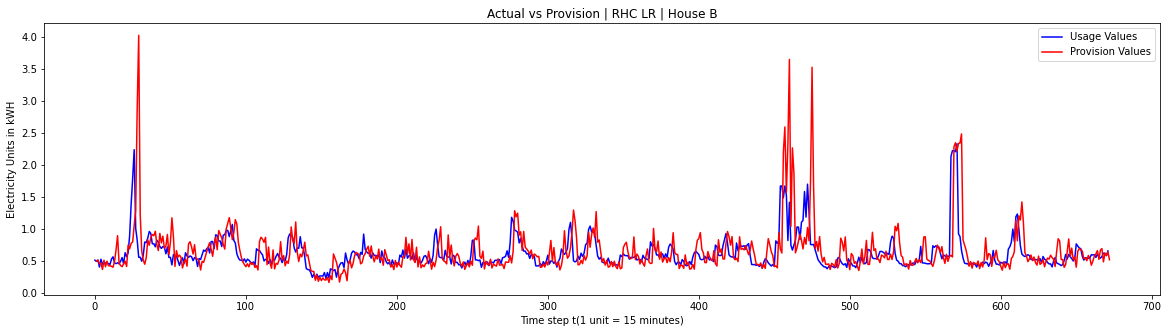

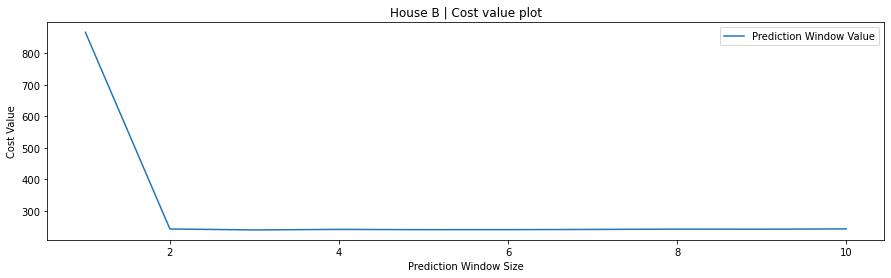

In [29]:

houseno = 0
predictData = predictions[houseno][0]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(calc_RHC(houseno, predictData.to_numpy(), i, 'LR'))

x = calc_RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'LR')
print("Optimal cost for RHC and Linear Regression found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_comparisonn(houses[houseno], decision_dict[houseno]['RHC_LR'], energyData[houseno], 'LR')
plot_RHC("House B | Cost value plot", windows, costs)

Optimal cost for RHC and Random Forest found at window size:  3

Optimal cost is:  224.34058586296203


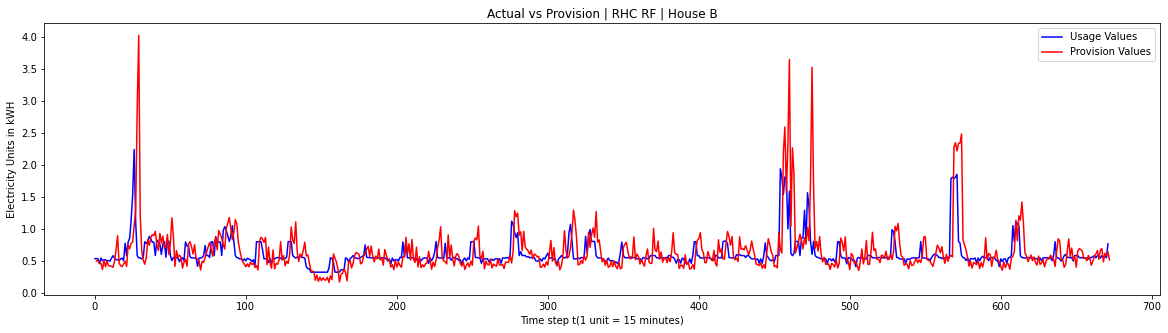

In [30]:

houseno = 0
predictData = predictions[houseno][1]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(calc_RHC(houseno, predictData.to_numpy(), i, 'RF'))

x = calc_RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'RF')
print("Optimal cost for RHC and Random Forest found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_comparisonn(houses[houseno], decision_dict[houseno]['RHC_RF'], energyData[houseno], 'RF')
# plot_RHC("House B Cost value plot", windows, costs)

Optimal cost for RHC and Linear Regression found at window size:  9

Optimal cost is:  7302.797485416918


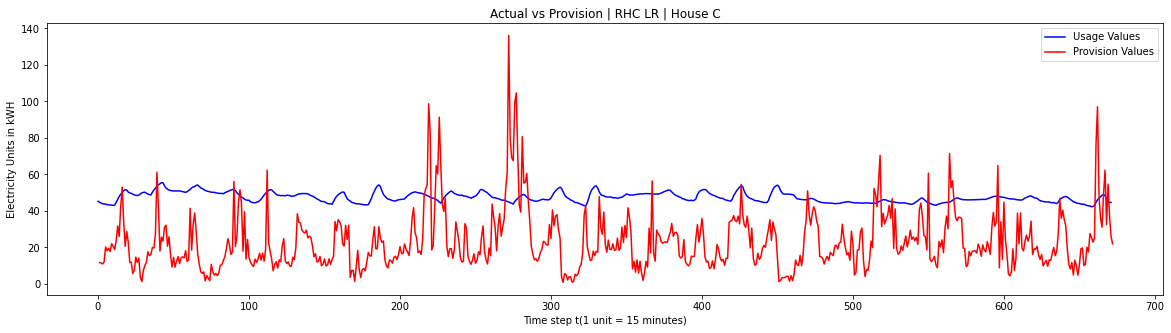

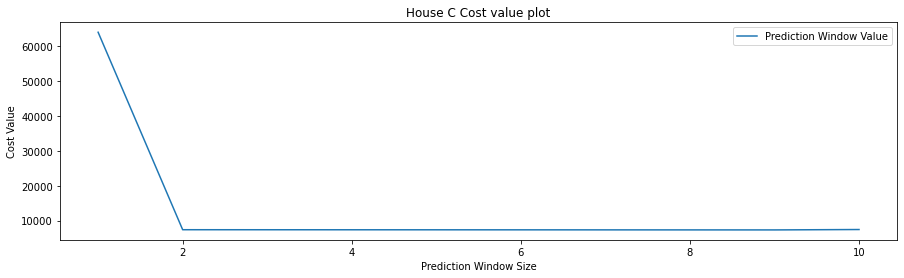

In [31]:

houseno = 1
predictData = predictions[houseno][0]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(calc_RHC(houseno, predictData.to_numpy(), i, 'LR'))
    
x = calc_RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'LR')
print("Optimal cost for RHC and Linear Regression found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_comparisonn(houses[houseno], decision_dict[houseno]['RHC_LR'], energyData[houseno], 'LR')
plot_RHC("House C Cost value plot", windows, costs)

Optimal cost for RHC and Random Forest found at window size:  9

Optimal cost is:  8354.494025515745


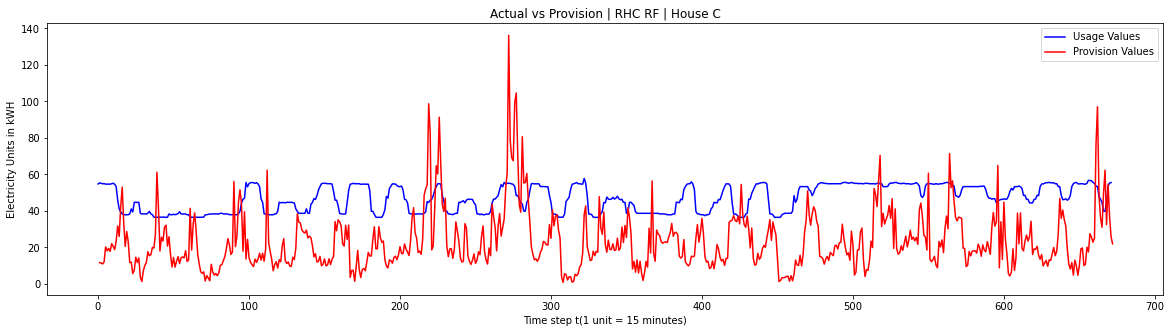

In [32]:

houseno = 1
predictData = predictions[houseno][1]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(calc_RHC(houseno, predictData.to_numpy(), i, 'RF'))
    
x = calc_RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'RF')
print("Optimal cost for RHC and Random Forest found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_comparisonn(houses[houseno], decision_dict[houseno]['RHC_RF'], energyData[houseno], 'RF')
# plot_RHC("House C Cost value plot", windows, costs)

Optimal cost for RHC and Linear Regression found at window size:  6

Optimal cost is:  17062.672793942707


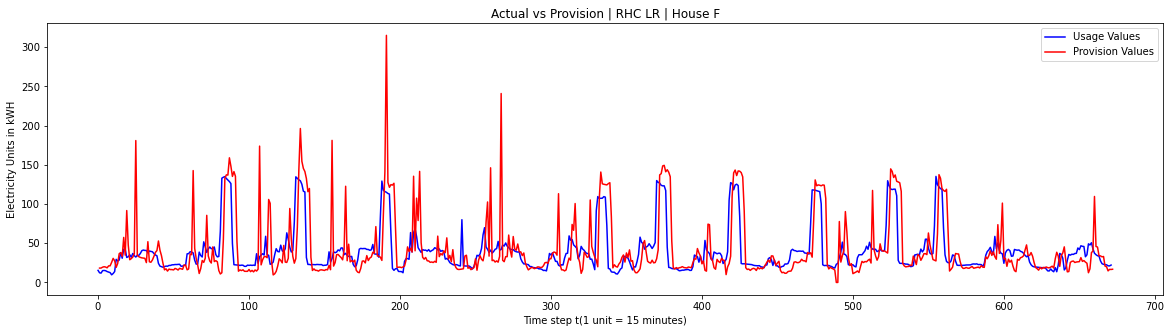

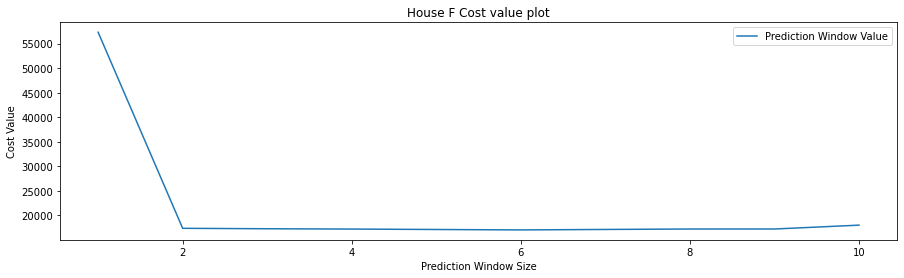

In [33]:

houseno = 2
predictData = predictions[houseno][0]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(calc_RHC(houseno, predictData.to_numpy(), i, 'LR'))
    
x = calc_RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'LR')
print("Optimal cost for RHC and Linear Regression found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_comparisonn(houses[houseno], decision_dict[houseno]['RHC_LR'], energyData[houseno], 'LR')
plot_RHC("House F Cost value plot", windows, costs)

Optimal cost for RHC and Random Forest Regression found at window size:  8

Optimal cost is:  17618.784092686874


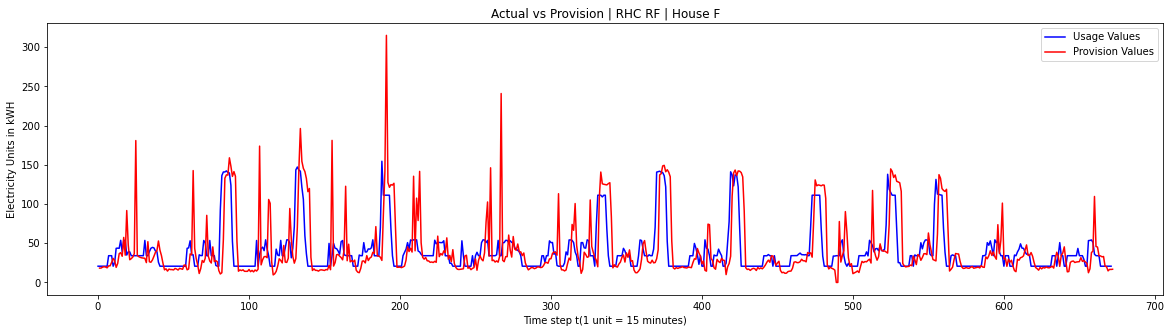

In [34]:

houseno = 2
predictData = predictions[houseno][1]
costs = []
windows = []
for i in range(1,11):
    windows.append(i)
    costs.append(calc_RHC(houseno, predictData.to_numpy(), i, 'RF'))
    
x = calc_RHC(houseno, predictData.to_numpy(), windows[costs.index(min(costs))], 'RF')
print("Optimal cost for RHC and Random Forest Regression found at window size: ", windows[costs.index(min(costs))])
print("\nOptimal cost is: ", x)
plot_comparisonn(houses[houseno], decision_dict[houseno]['RHC_RF'], energyData[houseno], 'RF')
# plot_RHC("House F Cost value plot", windows, costs)

Hence we calculated the optimal cost for 3 Houses B, C and F for Linear Regression and Random Forest. For House B, we see Random Forest Data performs quite better as compared to linear regression.

## Commitment Horizon Control

Now we run the predicted data through another online alogorithm called Commitment Horizon Control.

The optimal values is calculated as :  
$\sum \limits _{i=1} ^ {I} $price$*$x_optimal[i] + a$*$maximum(0,windowY[i]-x_optimal[i]) + b$*$abs(x_optimal[i]-x_optimal[i-1])  


We run the algorithm for a window size of 10 and the Commitment horizon values are varied to find the optimal cost of the CHC objective function.
Commitment Horizon values are varied from 2 to 11 and the different cost values are plotted against it.

In [35]:
def calc_CHC(houseno, y, predictionHorizon, commitmentHorizon, prediction_algo):
  T = 2*24*14;
  p = 0.4/2;
  a = 4/2;
  b = 4/2;
  optValues = np.zeros(T + 20);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    for i in range(0, commitmentHorizon):
      optValues[horizonStart + i] += x.value[i];

  optValues = optValues/commitmentHorizon

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  opt_dict[houseno]['CHC' + '_' + prediction_algo] = obj
  decision_dict[houseno]['CHC' + '_' + prediction_algo] = optValues

  return obj

In [36]:
def plot_CHC(title,windows, costs):
    fig = plt.figure(figsize=(15, 4))
    plt.title(title)
    plt.plot(windows, costs, label = "Commitment Horizon Value")
    plt.legend()
    plt.ylabel("Cost Value")
    plt.xlabel("Commitment Horizon Size")

In [37]:
def runCHC(houseno, predData, predictionHorizon, label):
    costs = []
    windows = []
    for i in range(2,11):
        windows.append(i)
        costs.append(calc_CHC(houseno, predData.to_numpy(), predictionHorizon, i, label))
    x = calc_CHC(houseno, predData.to_numpy(), predictionHorizon, windows[costs.index(min(costs))], label)
    print("Optimal cost for CHC found for House ", houses[houseno],  "at commitment horizon size ", windows[costs.index(min(costs))])
    print("\nOptimal cost is: ", x)
    plot_CHC("Commitment Horizon Values for CHC and "+label + "| House " + houses[houseno], windows,costs)

#### House B 

Optimal cost for CHC found for House  B at commitment horizon size  9

Optimal cost is:  172.49815019540276
Optimal cost for CHC found for House  B at commitment horizon size  9

Optimal cost is:  170.7424917838389


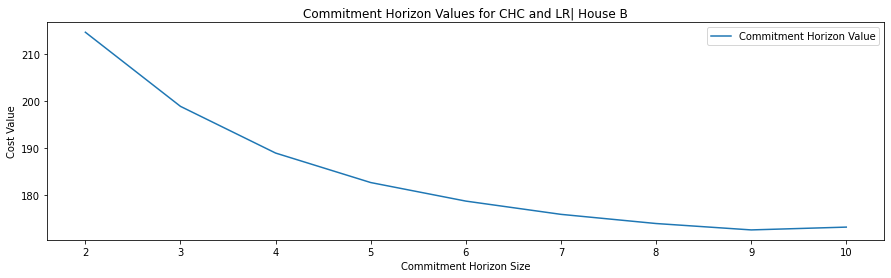

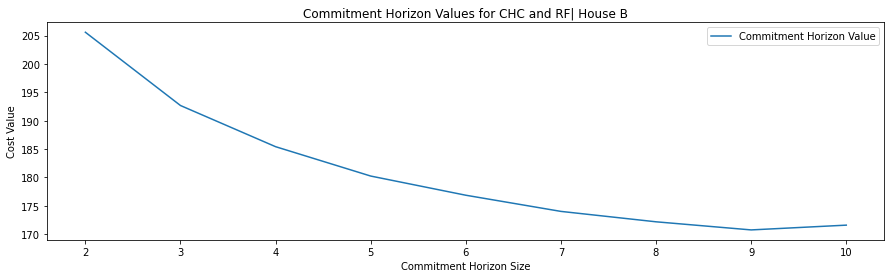

In [38]:
runCHC(0, predictions[0][0], 10, "LR" )

runCHC(0,  predictions[0][1], 10, "RF" )

#### House C

Optimal cost for CHC found for House  C at commitment horizon size  4

Optimal cost is:  7239.712430338386
Optimal cost for CHC found for House  C at commitment horizon size  5

Optimal cost is:  8138.516449446927


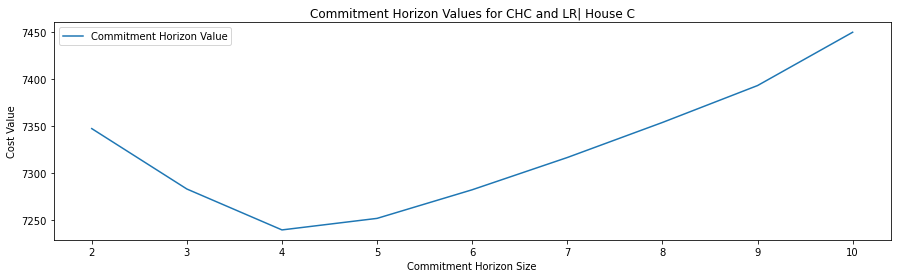

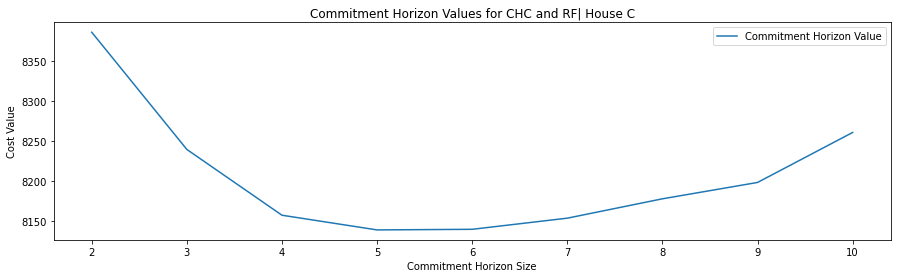

In [39]:

runCHC(1, predictions[1][0], 10, "LR" )

runCHC(1, predictions[1][1], 10, "RF" )

#### House F 

Optimal cost for CHC found for House  F at commitment horizon size  9

Optimal cost is:  13633.879284797671
Optimal cost for CHC found for House  F at commitment horizon size  9

Optimal cost is:  13766.367281932491


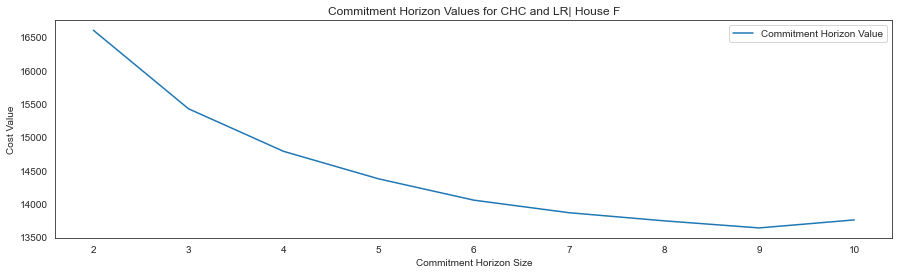

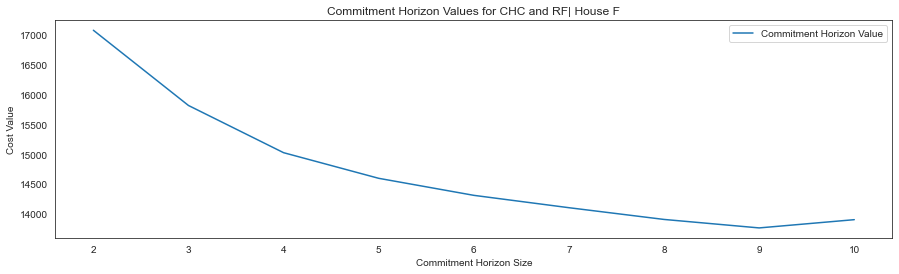

In [46]:

runCHC(2, predictions[2][0], 10, "LR" )

runCHC(2, predictions[2][1], 10, "RF" )

# Comparisons with Static Offline and Dynamic Offline Algorithms

We now compare different algorithms by plotting the cost for objective function for different houses. 

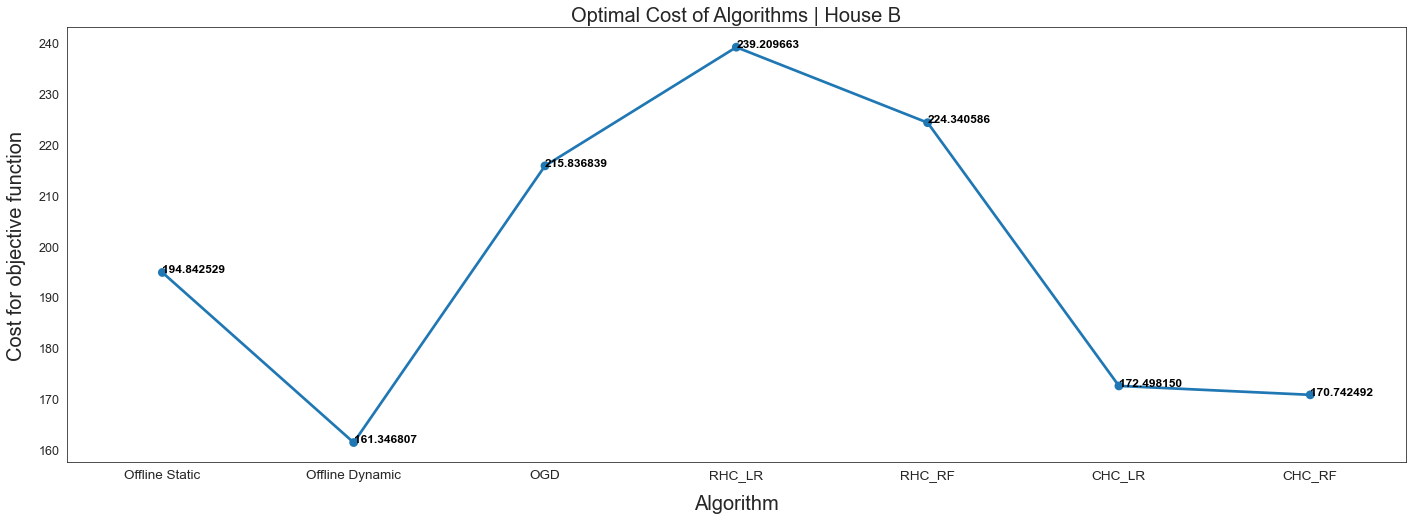

In [47]:
houseno = 0
sns.set_style("white")
fig = plt.figure(figsize=(24, 8))
opts = opt_dict[houseno]
x=list(opts.keys())
ax = sns.pointplot(x=list(opts.keys()), y=[score for score in opts.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(opts.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Cost for objective function', size=20, labelpad=12.5)
plt.xlabel('Algorithm', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Optimal Cost of Algorithms | House B', size=20)

plt.show()

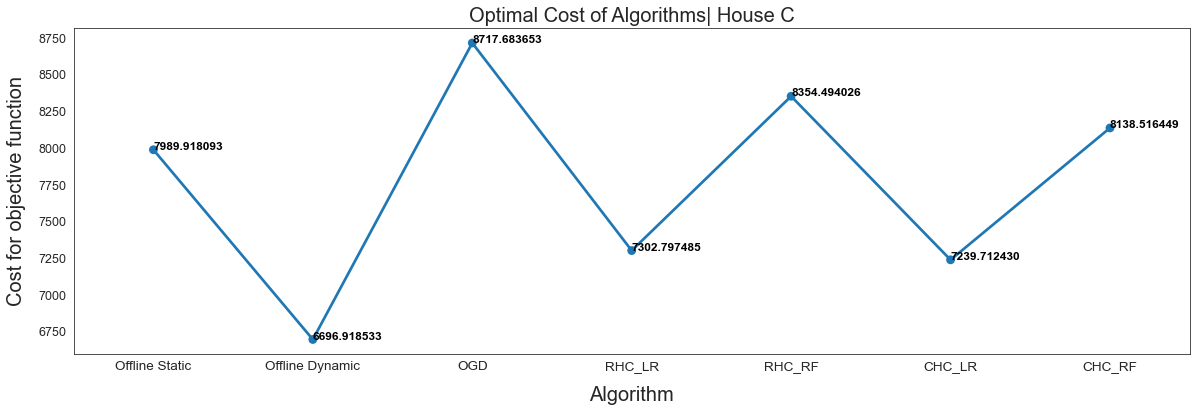

In [48]:
houseno = 1
sns.set_style("white")
fig = plt.figure(figsize=(20, 6))
opts = opt_dict[houseno]
x=list(opts.keys())
ax = sns.pointplot(x=list(opts.keys()), y=[score for score in opts.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(opts.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Cost for objective function', size=20, labelpad=12.5)
plt.xlabel('Algorithm', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Optimal Cost of Algorithms| House C', size=20)

plt.show()

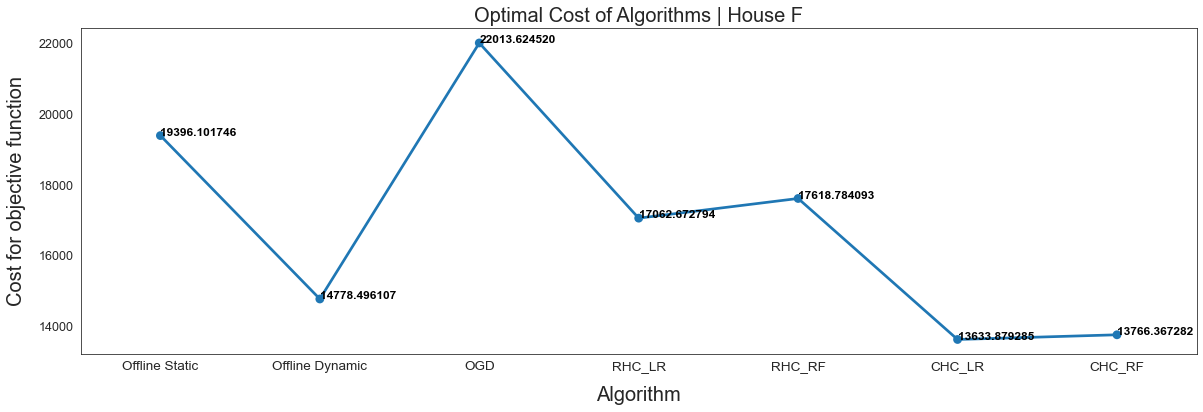

In [49]:
houseno = 2
sns.set_style("white")
fig = plt.figure(figsize=(20, 6))
opts = opt_dict[houseno]
x=list(opts.keys())
ax = sns.pointplot(x=list(opts.keys()), y=[score for score in opts.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(opts.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Cost for objective function', size=20, labelpad=12.5)
plt.xlabel('Algorithm', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Optimal Cost of Algorithms | House F', size=20)

plt.show()

We observe that CHC performed better than RHC and OGD in most of the cases. Specifically for House B

### Varying a and b for the best combination of control algorithm and prediction algorithm

Since we find for House B, the best performance is obeserved by CHC on Random Forest with commitment horizon size 9 with a= 4, b = 4. We now keep commitment horizon constant and vary first a keeping b as constant and then b, keeping a as constant. the values of penalty(a) and switching costs(b) in our objective function to see how our algorithms perform. We did this analysis and plotted graphs for each of the combination as shown below.

In [50]:
def chc_vary_and_b(y, predictionHorizon, commitmentHorizon, prediction_algo, a, b):
  T = 2*24*14;
  p = 0.4/2;
  a = a/2;
  b = b/2;
  optValues = np.zeros(T + 20);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    for i in range(0, commitmentHorizon):
      optValues[horizonStart + i] += x.value[i];

  optValues = optValues/commitmentHorizon

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  return obj

Text(0.5, 0, 'a')

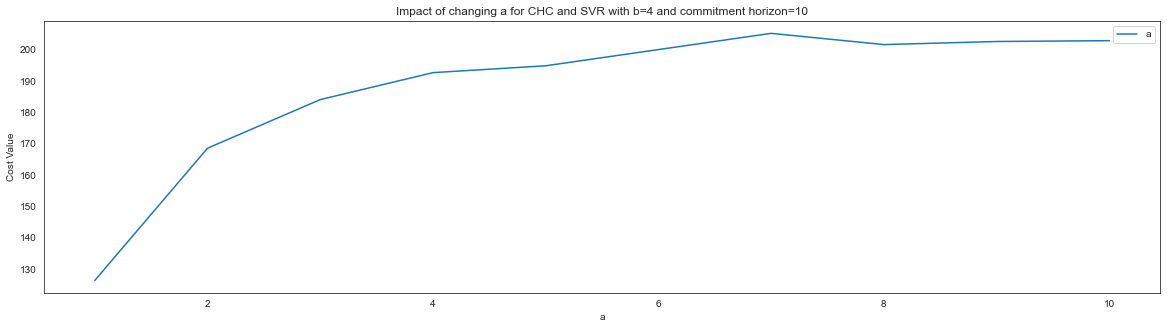

In [51]:
costs = []
windows = []
b = 4
for i in range(1,11):
    windows.append(i)
    costs.append(chc_vary_and_b(predictions[0][1].to_numpy(), 10, 3, 'RF', i, b))

fig = plt.figure(figsize=(20, 5))
plt.title("Impact of changing a for CHC and SVR with b=4 and commitment horizon=10")
plt.plot(windows, costs, label = "a")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("a")

The above graph shows the change in cost values for increasing the value of a, with commitment horizon size 10. The cost goes on increasing with increase in value of a.

Text(0.5, 0, 'b')

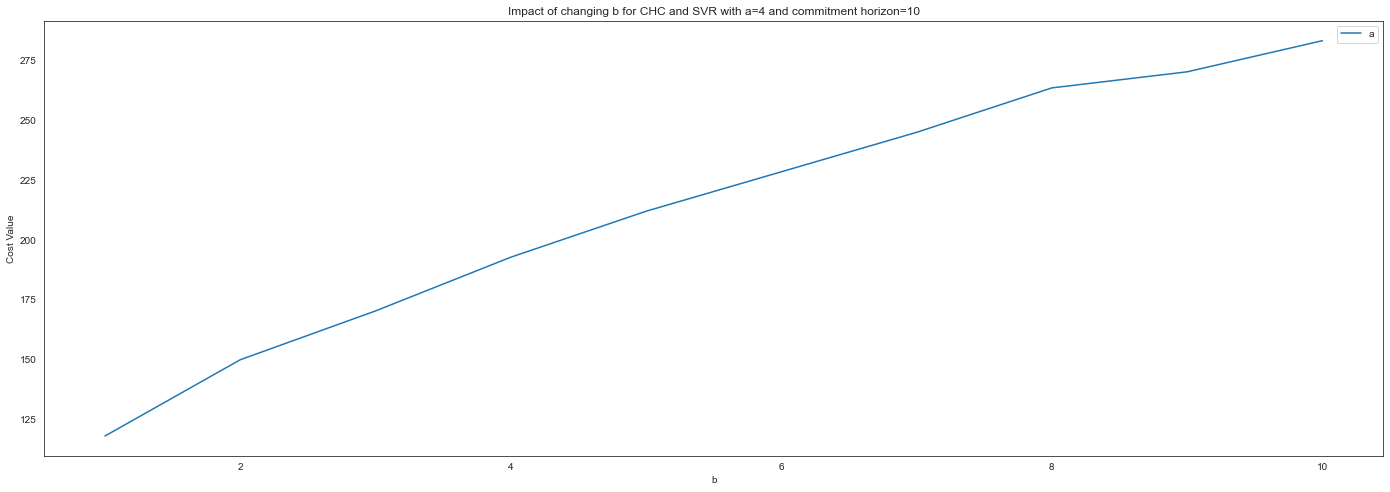

In [52]:
costs = []
windows = []
a = 4
for i in range(1,11):
    windows.append(i)
    costs.append(chc_vary_and_b(predictions[0][1].to_numpy(), 10, 3, 'RF', a, i))
    
fig = plt.figure(figsize=(24, 8))
plt.title("Impact of changing b for CHC and SVR with a=4 and commitment horizon=10")
plt.plot(windows, costs, label = "a")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("b")

The above graph shows the change in cost values for increasing the value of b, with commitment horizon size 10. The cost goes on increasing with increase in value of b, thus showing positive correlation with each other. 

# Algorithm Selection

If we wish to capture the best algorithm out of multiple algorithms for online convex optimization, we need to have constant performance criteria amongst all of them. Dynamic regret is taken factor is taken as the evalutaion criteria, and the objective function is minimized for algorithms. 

In [53]:
def online_gradient_descent_fixed_window(y, steps):
    n = 4
    x = [0.0] * (n + 1)
    x[1] = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for t in range(1, n):
      if (y[t] > x[t]):
          if (x[t] > x[t - 1]):
              slope = p - a + b;
          else:
              slope = p - a - b;
      else:
          if (x[t] > x[t - 1]):
              slope = p + b;
          else:
              slope = p - b;
      x[t + 1] = x[t] - steps * slope
    return x

def rhc_fixed_window(y, predictionHorizon, prediction_algo):
  T = 4;
  p = 0.4/2;
  a = 4/2;
  b = 4/2;
  optValues = np.zeros(T);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    optValues[horizonStart] = x.value[0];

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  return obj

def chc_fixed_window(y, predictionHorizon, commitmentHorizon, prediction_algo):
  T = 4;
  p = 0.4/2;
  a = 4/2;
  b = 4/2;
  optValues = np.zeros(T + 20);
  for horizonStart in range(0, T):
    horizonEnd = horizonStart + predictionHorizon
    windowY = y[horizonStart: horizonEnd]
    
    obj = 0;
    x = cp.Variable(predictionHorizon)
    
    for i in range(0, predictionHorizon):
        obj += p * x[i] + a * cp.maximum(0, windowY[i] - x[i])
        if i == 0:
            obj += b * cp.abs(x[i]); #because x(0) is 0
        else:
            obj += b * cp.abs(x[i] - x[i - 1])
    
    objective = cp.Minimize(obj)
    problem = cp.Problem(objective)
    result = problem.solve()
    
    for i in range(0, commitmentHorizon):
      optValues[horizonStart + i] += x.value[i];

  optValues = optValues/commitmentHorizon

  obj = 0;
  for i in range(0, T):
      obj += p * optValues[i] + a * max(0, y[i] - optValues[i])
      if i == 0:
          obj += b * abs(optValues[i]); #because x(0) is 0
      else:
          obj += b * abs(optValues[i] - optValues[i - 1])

  return obj

def cost_fixed_window(x, y):
    cost = 0
    p = 0.4/2
    a = 4/2
    b = 4/2
    for i in range(1, 5):
        cost += p * x[i] + a * max(0, y[i] - x[i] + b * abs(x[i] - x[i - 1]))
   
    return cost

def offline_dynamic_provision_fixed_window(y):
  p = 0.4/2
  a = 4/2
  b = 4/2
  x = cp.Variable(4)
  cost = 0

  for i in range(1,4):
      cost += p*x[i] + a*cp.maximum(0, y[i-1] - x[i]) + b*cp.abs(x[i]-x[i-1])
  
  objective = cp.Minimize(cost)
  constraints = [x[0] == 0, x[1:] >= 0]
  problem = cp.Problem(objective, constraints)
  result = problem.solve()
  opt = np.array(x.value)
  opt = np.insert(opt, 0, 0., axis=0)
  
  return opt

# Deterministic Approach

The algorithm followed in the Deterministic approach is as follows:


1. Choose a fixed window size. Ex. w = 4 and different time slots t1 & t2 at step size 4
2. Now, we need to iterate over the time horizon (T=672) with step size = window size
3. In each window, evaluate the objective function value for each algorithm
4. The algorithm which gives the value closest as compared to the offline algorithm wins that round or window size
5. We then measured the number of times OGD, RHC and CHC won respectively
6. In the end, The algorithm which won the maximum number of times is the winner


In [54]:
import operator

def deterministicApproach(y):
  win_ogd = 0;
  win_rhc = 0;
  win_chc = 0;
  obj_diff_dict = {}
  y = y.to_numpy()
  for i in range(1, 673):
    obj_ogd = cost_fixed_window(online_gradient_descent_fixed_window(y, 0.017), y[i:])
    obj_rhc = rhc_fixed_window(y[i:], 3, 'LR')
    obj_chc = chc_fixed_window(y[i:], 10, 9, 'LR')
    obj_offline_dynamic = cost_fixed_window(offline_dynamic_provision_fixed_window(y[i:]), y[i:])
    obj_diff_dict['OGD'] = abs(obj_offline_dynamic - obj_ogd)
    obj_diff_dict['RHC'] = abs(obj_offline_dynamic - obj_rhc)
    obj_diff_dict['CHC'] = abs(obj_offline_dynamic - obj_chc)
    optimal_algo = min(obj_diff_dict.items(), key=operator.itemgetter(1))[0]
    
    if optimal_algo == 'OGD':
      win_ogd += 1
    elif optimal_algo == 'RHC':
      win_rhc += 1
    else:
      win_chc += 1

  obj_win_dict = {}
  obj_win_dict['OGD'] = win_ogd
  obj_win_dict['RHC'] = win_rhc
  obj_win_dict['CHC'] = win_chc
  print(obj_win_dict)
  return max(obj_win_dict.items(), key=operator.itemgetter(1))[0]



In [55]:
print('The winner for deterministic approach for HOUSE B is: ',deterministicApproach(predictions[0][1]))

{'OGD': 89, 'RHC': 5, 'CHC': 578}
The winner for deterministic approach for HOUSE B is:  CHC


In [56]:
print('The winner for deterministic approach for HOUSE C is: ',deterministicApproach(predictions[1][1]))

{'OGD': 0, 'RHC': 0, 'CHC': 672}
The winner for deterministic approach for HOUSE C is:  CHC


In [57]:
print('The winner for deterministic approach for HOUSE F is: ',deterministicApproach(predictions[2][1]))

{'OGD': 183, 'RHC': 28, 'CHC': 461}
The winner for deterministic approach for HOUSE F is:  CHC


We observed that CHC won most of the times, providing the optimal value as compared to the offline algorithm. Our observed order was CHC > OGD > RHC

# Randomized Algorithm
The randomized algorithm is as follows.

1. We assign random weights to each algorithm. Ex. w1, w2, w3 
2. Pick a window size. Say 4
3. Run all 3 algorithms on each window
4. After each iteration,
        a. Rank the algorithms on the basis of performance
        b. Update the weights using any heuristic. We incremented the weight of winner by 0.1 and decreased the weight of loser by 0.1.
5. After all iterations, the final values of weights gives optimal value


In [58]:
import math

obj_wt_dict = [{}, {}, {}]

def randomizeAlgo(y, houseno):
  wt_ogd = 1/3;
  wt_rhc = 1/3;
  wt_chc = 1/3;
  obj_diff_dict = {}
  y = y.to_numpy()

  for i in range(1, 673):
    obj_ogd = cost_fixed_window(online_gradient_descent_fixed_window(y, 0.017), y[i:])
    obj_rhc = rhc_fixed_window(y[i:], 3, 'LR')
    obj_chc = chc_fixed_window(y[i:], 10, 9, 'LR')
    obj_offline_dynamic = cost_fixed_window(offline_dynamic_provision_fixed_window(y[i:]), y[i:])
    obj_diff_dict['OGD'] = abs(obj_offline_dynamic - obj_ogd)
    obj_diff_dict['RHC'] = abs(obj_offline_dynamic - obj_rhc)
    obj_diff_dict['CHC'] = abs(obj_offline_dynamic - obj_chc)
    most_optimal_algo = min(obj_diff_dict.items(), key=operator.itemgetter(1))[0]
    least_optimal_algo = max(obj_diff_dict.items(), key=operator.itemgetter(1))[0]
    
    
    if i > 1:
      if most_optimal_algo == 'OGD':
        wt_ogd += 0.0005
      elif most_optimal_algo == 'RHC':
        wt_rhc += 0.0005
      else:
        wt_chc += 0.0005

      if least_optimal_algo == 'OGD':
        wt_ogd -= 0.0005
      elif least_optimal_algo == 'RHC':
        wt_rhc -= 0.0005
      else:
        wt_chc -= 0.0005

    last_winner = most_optimal_algo
    last_loser = least_optimal_algo

  obj_wt_dict[houseno] = {}
  obj_wt_dict[houseno]['OGD'] = wt_ogd
  obj_wt_dict[houseno]['RHC'] = wt_rhc
  obj_wt_dict[houseno]['CHC'] = wt_chc
  return obj_wt_dict

In [59]:
randomizeAlgo(predictions[0][1], 0)
print('The final weights for randomized approach for House B is: ' , obj_wt_dict[0])

The final weights for randomized approach for House B is:  {'OGD': 0.37583333333333335, 'RHC': 0.0053333333333330235, 'CHC': 0.6188333333333204}


In [60]:
randomizeAlgo(predictions[1][1], 1)
print('The final weights for randomized approach for House C is: ' , obj_wt_dict[1])

The final weights for randomized approach for House C is:  {'OGD': 0.3333333333333333, 'RHC': -0.0021666666666669775, 'CHC': 0.6688333333333149}


In [61]:
randomizeAlgo(predictions[2][1], 2)
print('The final weights for randomized approach for House F is: ' , obj_wt_dict[2])

The final weights for randomized approach for House F is:  {'OGD': 0.4088333333333334, 'RHC': 0.03683333333333305, 'CHC': 0.5543333333333275}


For e.g. : For House B, Our final weights are **0.405 * OGD + 0.056 * RHC + 0.537*CHC** . We can see that the Sum of weights is equal to 1.

In [62]:
def algorithmsCompare(y, houseno):
  y = y.to_numpy()
  obj_deterministic = 0
  obj_offline_dynamic = 0
  obj_randomized = 0

  for i in range(1, 673):
    obj_deterministic += chc_fixed_window(y[i:], 10, 9, 'LR')
    obj_offline_dynamic += cost_fixed_window(offline_dynamic_provision_fixed_window(y[i:]), y[i:])
    obj_randomized += obj_wt_dict[houseno]['CHC']*chc_fixed_window(y[i:], 10, 9, 'LR')+obj_wt_dict[houseno]['RHC']*rhc_fixed_window(y[i:], 3, 'LR')+obj_wt_dict[houseno]['OGD']*cost_fixed_window(online_gradient_descent_fixed_window(y, 0.017), y[i:])

  obj_dict = {}
  obj_dict['Deterministic'] = obj_deterministic
  obj_dict['Offline Dynamic'] = obj_offline_dynamic
  obj_dict['Randomized'] = obj_randomized
  print("House "+houses[houseno]+" : Randomized Algorithm Selection") 
  print(obj_dict)

  return max(obj_dict.items(), key=operator.itemgetter(1))[0]

In [63]:
algorithmsCompare(predictions[0][1], 0)

House B : Randomized Algorithm Selection
{'Deterministic': 2978.3389955386256, 'Offline Dynamic': 3032.72725030731, 'Randomized': 3168.148907959773}


'Randomized'

In [64]:
algorithmsCompare(predictions[1][1], 1)

House C : Randomized Algorithm Selection
{'Deterministic': 218889.10749781667, 'Offline Dynamic': 213351.45390163022, 'Randomized': 230866.34005066013}


'Randomized'

In [65]:
algorithmsCompare(predictions[2][1], 2)

House F : Randomized Algorithm Selection
{'Deterministic': 200140.99417846955, 'Offline Dynamic': 211817.4963780749, 'Randomized': 209840.15772000447}


'Offline Dynamic'

In the above section we capture the objective function value for Offline Dynamic, Deterministic and Randomized approaches. The Randomized algorithm is the closest to Offline Dynamic (which is taken as a baseline here)and thus it performs better.